In [1]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from IPython.display import display_html
from sklearn.utils import estimator_html_repr
import numpy as np
from dbpedia_common import DataFrameRepository, add_categorical_target, get_single_stratified_split
from anomalies_analyser import compare_population_with_web
from models import get_svr_pipeline, get_linear_pipeline, ModelEvaluator

%matplotlib inline
train_df = DataFrameRepository(version='last').get()

In [36]:
train_df.head()

,subject,target,<http://dbpedia.org/ontology/areaLand>,<http://dbpedia.org/ontology/areaTotal>,<http://dbpedia.org/ontology/areaWater>,<http://dbpedia.org/ontology/elevation>,<http://dbpedia.org/ontology/populationDensity>,areaLand>NAN,areaTotal>NAN,areaWater>NAN,elevation>NAN,populationDensity>NAN,areaCode#count,areaLand#count,areaTotal#count,areaWater#count,birthPlace?inv#count,city?inv#count,country#count,countySeat?inv#count,deathPlace?inv#count,district#count,elevation#count,foundingDate#count,governmentType#count,gridReference#count,ground?inv#count,headquarter?inv#count,hometown?inv#count,largestCity?inv#count,licenceNumber#count,location?inv#count,motto#count,nearestCity?inv#count,originalName#count,politicalLeader#count,populationAsOf#count,populationDensity#count,postalCode#count,residence?inv#count,restingPlace?inv#count,routeEnd?inv#count,routeJunction?inv#count,routeStart?inv#count,subdivision#count,subdivision?inv#count,timeZone#count,type#count,utcOffset#count,22-rdf-syntax-ns#type#count,rdf-schema#seeAlso#count,homepage#count,name#count,nick#count,rare_rel#count,total_rel#count,unique_rel#count,place_type#cat,utc_offset#cat,country#cat
0,<http://dbpedia.org/resource/'Amran>,290792.000,0.000,0.000,0.000,0.000,0.000,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,9,0,0,1,0,2,30,10,City,3,Yemen
1,"<http://dbpedia.org/resource/'t_Zand,_Schagen>",2320.000,0.000,0.000,0.000,0.000,0.000,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,8,0,0,1,0,1,34,14,Town,"1,2",Netherlands
2,<http://dbpedia.org/resource/100_Mile_House>,1980.000,0.000,53290000.000,0.000,927.000,35.400,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,3,0,1,0,0,0,0,0,0,3,0,1,1,1,8,0,1,2,0,3,54,30,Town,-8,NAN
3,<http://dbpedia.org/resource/13th_district_of_...,120256.000,0.000,13430000.000,0.000,0.000,8954.000,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,1,2,0,0,0,0,0,4,1,2,1,3,8,0,1,3,0,4,64,30,Region,"1,2",Hungary
4,<http://dbpedia.org/resource/16th_district_of_...,73486.000,0.000,33510000.000,0.000,0.000,2192.000,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2,1,0,1,2,0,0,0,0,0,2,1,2,1,3,8,0,1,3,0,4,64,34,Region,"1,2",Hungary


In [21]:
display_html(estimator_html_repr(get_svr_pipeline()), raw=True)

Pipeline Pipeline(steps=[('preprocessing',
 Pipeline(steps=[('countries',
 CategoricalThresholdTransformer(column='country#cat',
 log=False,
 threshold=0.97)),
 ('utc_offset',
 CategoricalThresholdTransformer(column='utc_offset#cat',
 log=False,
 threshold=0.95)),
 ('calculated_pop',
 CalculatedPopTransformer())])),
 ('transformations',
 ColumnTransformer(remainder='passthrough',
 t...
 LogTransformer(exclude_columns=[])),
 ('scale',
 MinMaxScaler())]),
 ),
 ('categorical',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore'))]),
 )])),
 ('model', SVR(C=0.5, cache_size=1999, epsilon=0.01))]) preprocessing: Pipeline Pipeline(steps=[('countries',
 CategoricalThresholdTransformer(column='country#cat',
 log=False, threshold=0.97)),
 ('utc_offset',
 CategoricalThresholdTransformer(column='utc_offset#cat',
 log=False, threshold=0.95)),
 ('calculated_pop', CalculatedPopTransformer())]) CategoricalThresholdTransformer CategoricalThresholdTransformer(column='country#cat', log=False, threshold=0.97) CategoricalThresholdTransformer CategoricalThresholdTransformer(column='utc_offset#cat', log=False,
 threshold=0.95) CalculatedPopTransformer CalculatedPopTransformer() transformations: ColumnTransformer ColumnTransformer(remainder='passthrough',
 transformers=[('numeric_log',
 Pipeline(steps=[('log',
 LogTransformer(exclude_columns=[])),
 ('scale', MinMaxScaler())]),
 ),
 ('categorical',
 Pipeline(steps=[('onehot',
 OneHotEncoder(handle_unknown='ignore'))]),
 )]) numeric_log LogTransformer LogTransformer(exclude_columns=[]) MinMaxScaler MinMaxScaler() categorical OneHotEncoder OneHotEncoder(handle_unknown='ignore') SVR SVR(C=0.5, cache_size=1999, epsilon=0.01)

In [20]:
# Base Regressor
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy='mean')
X = train_df.drop(columns=['subject', 'target'])
y = np.log10(train_df.target)
dummy_regr.fit(X, y)

print(f'DummyRegressor RMSLE: {mean_squared_error(y, dummy_regr.predict(X)) ** 0.5}')
print(f'DummyRegressor RMSE: {mean_squared_error(10**y, 10**dummy_regr.predict(X)) ** 0.5}')

DummyRegressor RMSLE: 0.7004748000050688
DummyRegressor RMSE: 534893.987881911


### Best params after Gridsearch with CV=5

********************
Test RMSLE: 0.2795483459394547
Test RMSE: 319179.04706556036
********************
Train RMSLE: 0.2548769758519095
Train RMSE: 195432.40368756463


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
11706,Funafuti>,1.730,3.801,5.531,6320.000,339784.024,333464.024,<http://dbpedia.org/resource/Funafuti>
21842,Merkezefendi>,-1.715,5.420,3.705,262825.000,5071.670,-257753.330,<http://dbpedia.org/resource/Merkezefendi>
34796,Tiyeglow>,-1.606,5.978,4.372,950000.000,23535.552,-926464.448,<http://dbpedia.org/resource/Tiyeglow>
1926,Ba'a>,1.574,3.065,4.638,1161.000,43500.069,42339.069,<http://dbpedia.org/resource/Ba'a>
26787,Pibor>,1.541,3.000,4.541,1000.000,34752.955,33752.955,<http://dbpedia.org/resource/Pibor>
...,...,...,...,...,...,...,...,...
7200,"Clinton_(CDP),_Maine>",0.000,3.152,3.152,1419.000,1419.207,0.207,"<http://dbpedia.org/resource/Clinton_(CDP),_Ma..."
13677,"Haddon_Heights,_New_Jersey>",-0.000,3.873,3.873,7473.000,7471.999,-1.001,"<http://dbpedia.org/resource/Haddon_Heights,_N..."
18988,"Lansing,_Illinois>",0.000,4.452,4.452,28331.000,28332.397,1.397,"<http://dbpedia.org/resource/Lansing,_Illinois>"
20146,"Lower_Allen,_Pennsylvania>",0.000,3.826,3.826,6694.000,6694.323,0.323,"<http://dbpedia.org/resource/Lower_Allen,_Penn..."


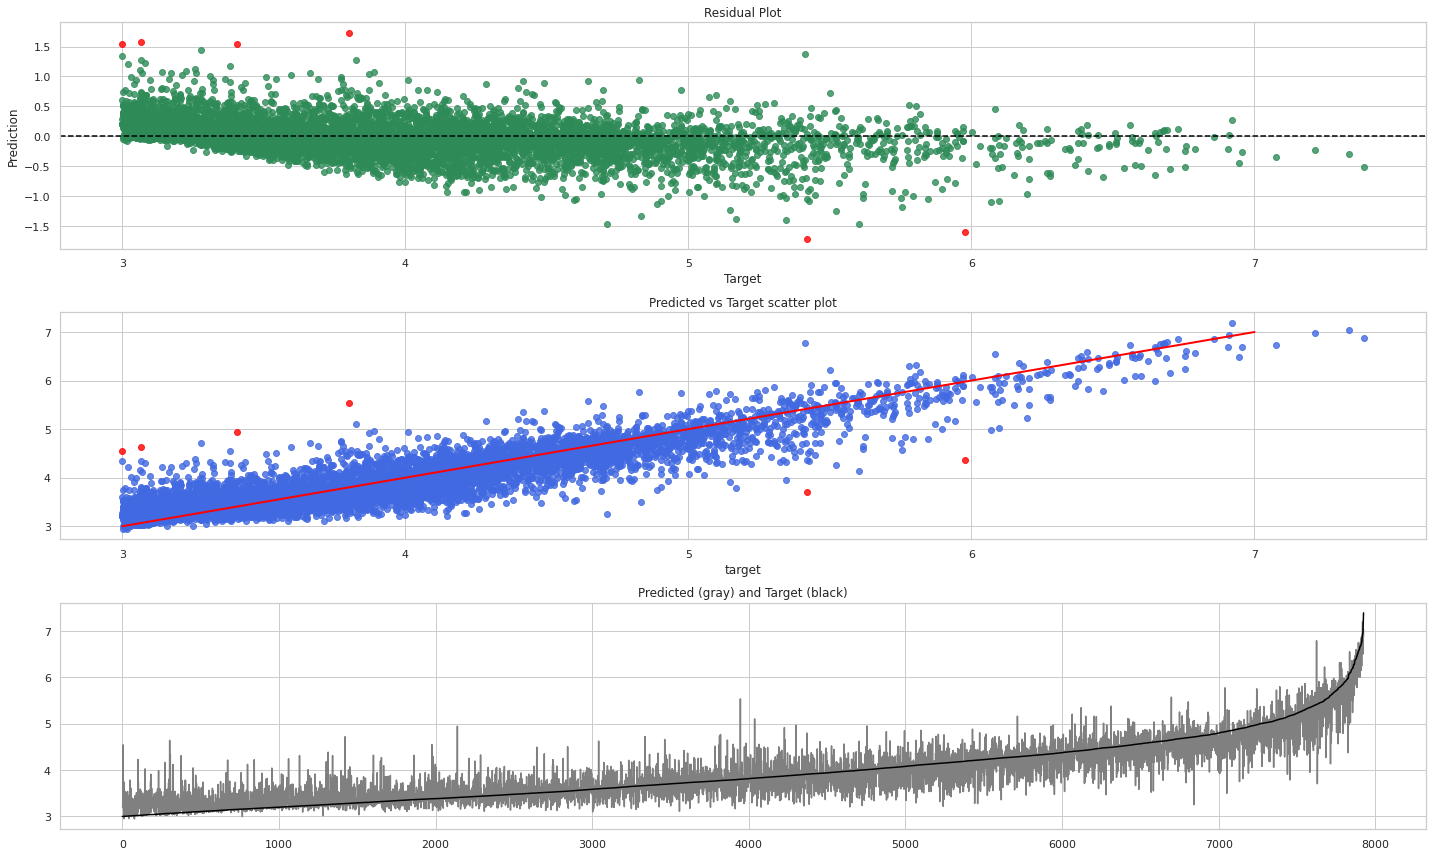

In [23]:
train_df = DataFrameRepository(version='last').get()

train_df = add_categorical_target(train_df, 'target_category')
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(split.split(train_df, train_df["target_category"]))


X = train_df.drop(columns=['subject', 'target', 'target_category'])
y = np.log10(train_df.target)

X_train, y_train = X.loc[train_index], y.loc[train_index]
X_test, y_test = X.loc[test_index], y.loc[test_index]

y_test = y_test.sort_values() # These two lines are to have a nice plot below
X_test = X_test.reindex(y_test.index)

pipeline = get_svr_pipeline(countries_threshold=0.97, utc_threshold=0.95)
model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
evaluator.plot_results()
error_analysis_df = evaluator.get_error_analysis(train_df)
error_analysis_df

In [24]:
compare_population_with_web(error_analysis_df, limit=10).head(10)

0 Errors found while parsing wikipedia webpage. Make a manual check for: []
There are 0 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
0,Funafuti,False,6320.000,6320,0.000,,https://en.wikipedia.org/wiki/Funafuti,<http://dbpedia.org/resource/Funafuti>
1,Merkezefendi,False,262825.000,262825,0.000,,https://en.wikipedia.org/wiki/Merkezefendi,<http://dbpedia.org/resource/Merkezefendi>
2,Tiyeglow,False,950000.000,950000,0.000,,https://en.wikipedia.org/wiki/Tiyeglow,<http://dbpedia.org/resource/Tiyeglow>
3,Ba'a,False,1161.000,1161,0.000,,https://en.wikipedia.org/wiki/Ba%27a,<http://dbpedia.org/resource/Ba'a>
4,Pibor,False,1000.000,1000,0.000,,https://en.wikipedia.org/wiki/Pibor,<http://dbpedia.org/resource/Pibor>
5,Fiorentino,False,2548.000,2548,0.000,,https://en.wikipedia.org/wiki/Fiorentino,<http://dbpedia.org/resource/Fiorentino>
6,Bawshar,False,402023.000,402023,0.000,,https://en.wikipedia.org/wiki/Bawshar,<http://dbpedia.org/resource/Bawshar>
7,"Bret_Harte,_California",False,51481.000,51481,0.000,,https://en.wikipedia.org/wiki/Bret_Harte%2C_Ca...,"<http://dbpedia.org/resource/Bret_Harte,_Calif..."
8,"Philipsburg,_Sint_Maarten",False,1894.000,1894,0.000,,https://en.wikipedia.org/wiki/Philipsburg%2C_S...,"<http://dbpedia.org/resource/Philipsburg,_Sint..."
9,Guéckédou,False,221715.000,221715,0.000,,https://en.wikipedia.org/wiki/Gu%C3%A9ck%C3%A9dou,<http://dbpedia.org/resource/Guéckédou>


********************
Test RMSLE: 0.2791109936314143
Test RMSE: 301026.3497873317
********************
Train RMSLE: 0.25395839532640496
Train RMSE: 167633.09746062758


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
11706,Funafuti>,1.713,3.801,5.514,6320.000,326441.924,320121.924,<http://dbpedia.org/resource/Funafuti>
21842,Merkezefendi>,-1.705,5.420,3.715,262825.000,5189.621,-257635.379,<http://dbpedia.org/resource/Merkezefendi>
34796,Tiyeglow>,-1.603,5.978,4.375,950000.000,23725.212,-926274.788,<http://dbpedia.org/resource/Tiyeglow>
1926,Ba'a>,1.547,3.065,4.612,1161.000,40934.190,39773.190,<http://dbpedia.org/resource/Ba'a>
11100,Fiorentino>,1.527,3.406,4.933,2548.000,85662.767,83114.767,<http://dbpedia.org/resource/Fiorentino>
...,...,...,...,...,...,...,...,...
21558,"McConnellstown,_Pennsylvania>",0.000,3.077,3.077,1194.000,1194.229,0.229,"<http://dbpedia.org/resource/McConnellstown,_P..."
33016,"Stearns,_Kentucky>",-0.000,3.200,3.200,1586.000,1585.758,-0.242,"<http://dbpedia.org/resource/Stearns,_Kentucky>"
36991,"Wanakah,_New_York>",-0.000,3.505,3.505,3199.000,3198.574,-0.426,"<http://dbpedia.org/resource/Wanakah,_New_York>"
29243,"Rome,_Maine>",0.000,3.004,3.004,1010.000,1010.063,0.063,"<http://dbpedia.org/resource/Rome,_Maine>"


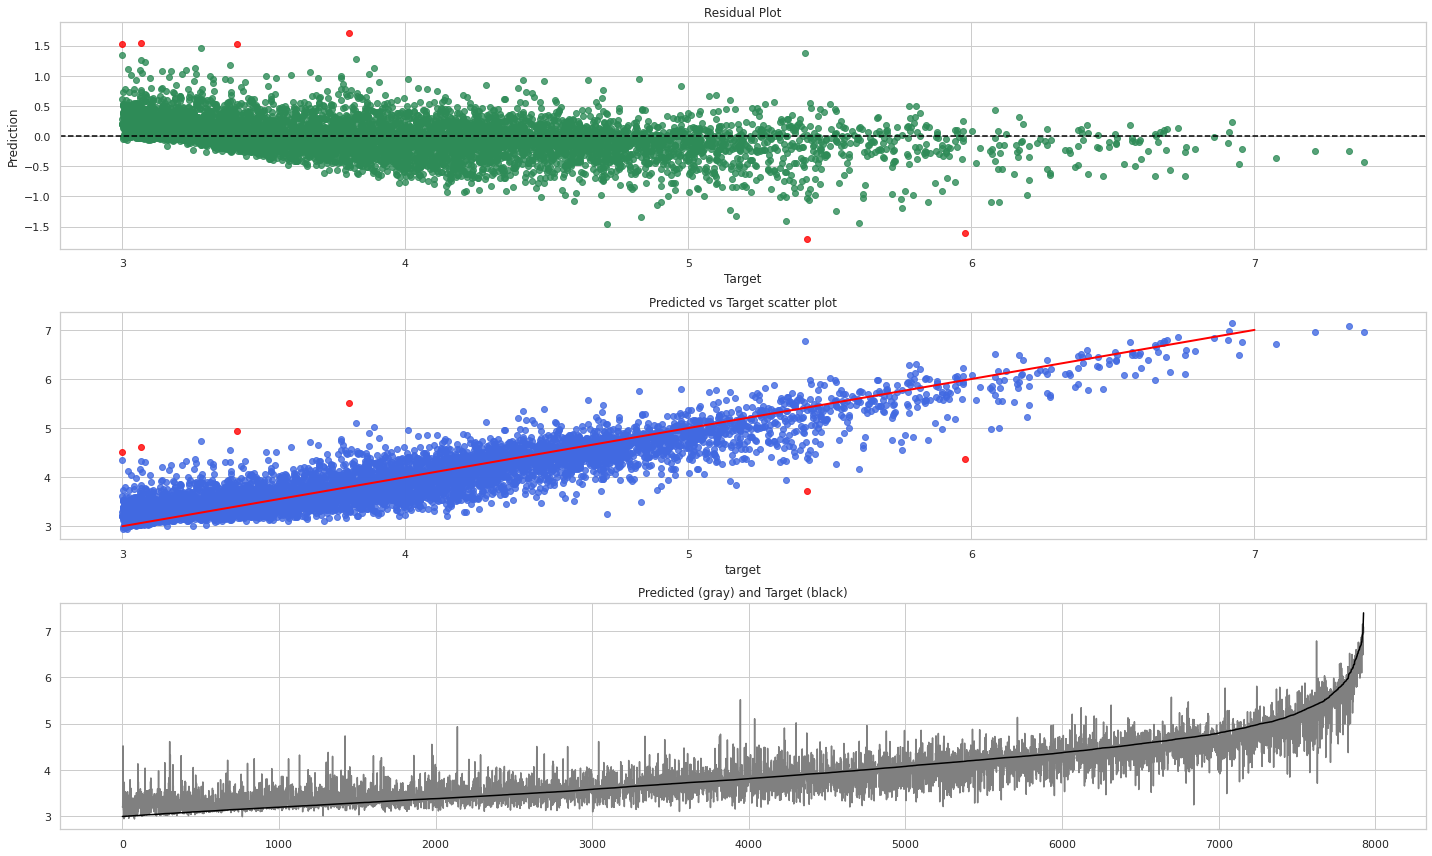

In [6]:
train_df = DataFrameRepository(version='last').get()
train_index, test_index = get_single_stratified_split(df)

X = train_df.drop(columns=['subject', 'target'])
y = np.log10(train_df.target)

X_train, y_train = X.loc[train_index], y.loc[train_index]
X_test, y_test = X.loc[test_index], y.loc[test_index]
y_test = y_test.sort_values() # These two lines are to have a nice plot below
X_test = X_test.reindex(y_test.index)

pipeline = get_svr_pipeline(countries_threshold=0.97, utc_threshold=0.95)
model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
evaluator.plot_results()
error_analysis_df = evaluator.get_error_analysis(train_df)
error_analysis_df

#### 10 fold CV

In [32]:
train_df = DataFrameRepository(version='last').get()

train_df = add_categorical_target(train_df, 'target_category')
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_split_generator = split.split(train_df, train_df['target_category'])

X = train_df.drop(columns=['subject', 'target', 'target_category'])
y = np.log10(train_df.target)

rmse = make_scorer(lambda a,b: mean_squared_error(a,b)**0.5, greater_is_better=False)
model = TransformedTargetRegressor(regressor=get_svr_pipeline(countries_threshold=0.97, utc_threshold=0.95), transformer=MinMaxScaler())

scores = cross_validate(model, X, y, cv=strat_split_generator, scoring=rmse ,return_train_score=True)
print(f'Test: Mean RMSLE of {scores["test_score"].mean()}')
print(f'Train: Mean RMSLE of {scores["train_score"].mean()}')

Test: Mean RMSLE of -0.28078924470886524
Train: Mean RMSLE of -0.25516038348888415
